# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 


In [1]:
import cv2
import glob
import pickle
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.contrib.layers import flatten
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

print("TensorFlow version: ", tf.__version__)

TensorFlow version:  1.3.0


#### All necessary imports - done.

---
## Step 0: Load The Data

In [2]:
# Load pickled data
training_file = "../data/train.p"
validation_file= "../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


---

## Step 1: Dataset Summary & Exploration

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
n_train = len(X_train)      # train features
n_validation = len(X_valid) # validation features
n_test = len(X_test)        # test features
n_classes = len(np.unique(y_train))
image_shape = X_train[0].shape

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Image data shape =", y_train.shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Image data shape = (34799,)
Number of classes = 43


### Notes: 
We have 43 different traffic signs, and a total of 34799 samples for training. Additional 12630 samples will be used for testing that should not be involved in the training process in order to keep them isolated and avoid influencing the data.

### Include an exploratory visualization of the dataset

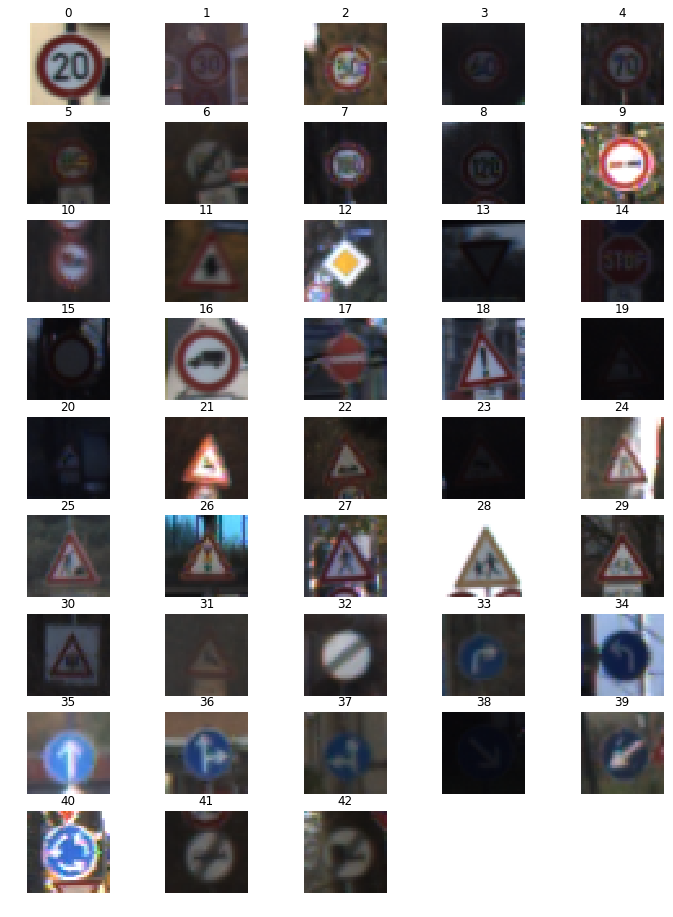

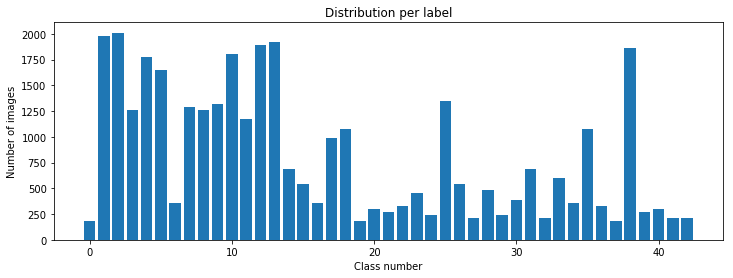

In [4]:
# Plot number of images per class
count_of_samples=[]
plt.figure(figsize=(12, 16))
for i in range(0, n_classes):
    plt.subplot(9, 5, i+1)
    x_selected = X_train[y_train == i]
    plt.imshow(x_selected[0, :, :, :])
    plt.title(i)
    plt.axis('off')
    count_of_samples.append(len(x_selected))
plt.show()

plt.figure(figsize=(12, 4))
plt.bar(range(0, n_classes), count_of_samples)
plt.title("Distribution per label")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()


### Notes: 
There's a big disbalance for some samples, these could be equalised by creating new training data from the existing images. Equalising the sample set would also avoid a probabilistic tendency to predict labels with more training data over labels with less.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

### Pre-process the Data Set (normalization, grayscale, etc.)

In [5]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def ProcessDataSet(X, y):
    meanDivider = np.mean(X);
    Xf = (np.array(X) - meanDivider) / 255           # normalize
    Xf = np.sum(Xf/3, axis=3, keepdims=True)         # grayscale
    #Xf, y = shuffle(Xf, y)                           # shuffle
    print("Mean:  ", np.mean(X), " => ", np.mean(Xf))
    print("Shape =", Xf.shape)
    return (Xf, y)

print('Preprocessing training data...')
(X_train, y_train) = ProcessDataSet(X_train, y_train)
print('Preprocessing validation data...')
(X_valid, y_valid) = ProcessDataSet(X_valid, y_valid)
print('Preprocessing test data...')
(X_test, y_test) = ProcessDataSet(X_test, y_test)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=42)


Preprocessing training data...
Mean:   82.677589037  =>  -6.10002133131e-18
Shape = (34799, 32, 32, 1)
Preprocessing validation data...
Mean:   83.5564273756  =>  2.16254326112e-17
Shape = (4410, 32, 32, 1)
Preprocessing test data...
Mean:   82.1484603612  =>  2.83225541199e-17
Shape = (12630, 32, 32, 1)


### Notes:
I'm not doing a lot of preprocessing, since (in my opinion) it would be better to check how far I can get with what I have. If I get enough accuracy with a smaller set, then adding more learning data should only improve accuracy. Equalising the number of samples per label sounds somehow pointless, since, taken that I have ways to extend my samples by adding pre-processing, why not doing it for all of the samples? Then again, adding more samples of just those of which I have fewer would mean better performance for those ones without adding more time-consuming learning data for samples that already perform good.

Zero centering the mean value proved to help a lot.
The Suffle broke the prediction of the extra samples, I'm doing something wrong here, but couldn't find the error.

There are a few basic transformations I would add, like 90 degrees rotations (maybe even 45 degree steps) and mirroring. I believe those would add some additional performance in prediction.

### Model Architecture

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

def ConvNN(x, color_channels = 3):
    mu = 0
    sigma = 0.1
    
    #print("Initial shape: ", x.shape)
    
    # First layer, conv 32x32xN => 28x28x6
    conv1_size_out = 6
    conv1_w = tf.Variable(tf.truncated_normal(shape = (5, 5, color_channels, conv1_size_out), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(conv1_size_out))
    conv1 = tf.nn.conv2d(x, conv1_w, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activate and pool 28x28x6 => 14x14x6
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #print("conv1 shape: ", conv1.shape)

    # Second layer, conv 14x14x6 => 10x10x16
    conv2_size_out = 16
    conv2_w = tf.Variable(tf.truncated_normal(shape = (5, 5, conv1_size_out, conv2_size_out), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(conv2_size_out))
    conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activate and pool 10x10x16 => 5x5x16
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #print("conv2 shape: ", conv2.shape)

    # Flatten 5x5x26 => 400
    flat1_size_out = 400
    flat1 = flatten(conv2)
    
    #print("flat1 shape: ", flat1.shape)

    conn1_size_out = 200
    conn1_w = tf.Variable(tf.truncated_normal(shape = (flat1_size_out, conn1_size_out), mean = mu, stddev = sigma))
    conn1_b = tf.Variable(tf.zeros(conn1_size_out))
    conn1 = tf.matmul(flat1, conn1_w) + conn1_b
    
    conn1 = tf.nn.relu(conn1)
    conn1 = tf.nn.dropout(conn1, keep_prob)
    
    #print("conn1 shape: ", conn1.shape)

    #conn1b_size_out = 200
    #conn1b_w = tf.Variable(tf.truncated_normal(shape = (conn1_size_out, conn1b_size_out), mean = mu, stddev = sigma))
    #conn1b_b = tf.Variable(tf.zeros(conn1b_size_out))
    #conn1b = tf.matmul(conn1, conn1b_w) + conn1b_b
    
    #conn1b = tf.nn.relu(conn1b)
    #conn1b = tf.nn.dropout(conn1b, keep_prob)
    
    #conn1_size_out = conn1b_size_out
    #conn1 = conn1b
    
    #print("conn1b shape: ", conn1.shape)

    conn2_size_out = 100
    conn2_w = tf.Variable(tf.truncated_normal(shape=(conn1_size_out, conn2_size_out), mean = mu, stddev = sigma))
    conn2_b = tf.Variable(tf.zeros(conn2_size_out))
    conn2 = tf.matmul(conn1, conn2_w) + conn2_b
    
    conn2 = tf.nn.relu(conn2)
    conn2 = tf.nn.dropout(conn2, keep_prob)

    # bypass conn2
    #conn2 = conn1 
    #conn2_size_out = conn1_size_out
    
    #print("conn2 shape: ", conn2.shape)

    # Final layer, match to expected number of classes
    conn3_size_out = 43
    conn3_w = tf.Variable(tf.truncated_normal(shape=(conn2_size_out, conn3_size_out), mean = mu, stddev = sigma))
    conn3_b = tf.Variable(tf.zeros(conn3_size_out))
    conn3 = tf.matmul(conn2, conn3_w) + conn3_b
    
    #print("conn3 shape: ", conn3.shape)

    return conn3


### Notes:
The basic structure is a LeNet network. Layers are (N is the number of input color channels):
1. Convolutional 32x32xN => 28x28x6  + ReLu + MaxPool
2. Convolutional 14x14x6 => 10x10x16 + ReLu + MaxPool
3. Flatten        5x5x26 => 400
4. Connected         400 => 200      + ReLu + Dropout
5. Connected         200 => 100      + ReLu + Dropout
6. Connected         100 => 43

I also tried adding another connected layer (400=><b>300</b>=>200=>100=>43) but it didn't add much. I would have liked to try a Leaky ReLu, but the TensorFlow version running does not support it.

See the performance of different combinations in the next section.

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [7]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

EPOCHS = 60
BATCH_SIZE = 128
rate = 0.0009

channels = X_train[0].shape[2]

x = tf.placeholder(tf.float32, (None, 32, 32, channels))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units
one_hot_y = tf.one_hot(y, 43)

logits = ConvNN(x, channels)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


### Test runs:

<i>Epochs, batch size, learning rate => success rate (modifiers)</i>
 -  10, 128, 0.0009 => 93.7%
 -  20, 200, 0.0009 => 94.6%
 -  20, 100, 0.0009 => 95.3%
 -  20, 100, 0.002  => 94.8%
 -  15, 300, 0.0005 => 91.4%
 -  35, 100, 0.0005 => 94.4%
 -  10, 128, 0.0009 => 90.5% (w/avg_pool(), keep_prob 0.5)
 -  10, 128, 0.0009 => 94.1% (w/max_pool(), keep_prob 0.5)
 -  10, 128, 0.0009 => 92.8% (w/max_pool(), keep_prob 0.8)
 -  10, 128, 0.0009 => 93.9% (w/max_pool(), keep_prob 0.5)
 -  10, 128, 0.0009 => 88.0% (w/max_pool(), keep_prob 0.3)
 -  35, 128, 0.0009 => 96.6% (w/max_pool(), keep_prob 0.6)
 -  35, 128, 0.0009 => 93.8% (no Conn2 layer)
 -  35, 128, 0.0009 => ----% (leaky ReLu after conv1) -- no LeakyReLu in TF 1.3
 -  35, 128, 0.0009 => 95.9% (with conn1b layer)
 -  35, 128, 0.009  => 88.8% (with conn1b layer, rollercoaster progress)
 -  35, 128, 0.001  => 95.6% (with conn1b layer)
 -  45, 128, 0.0004 => 93.9%
 -  50, 100, 0.0009 => 96.9%

### Notes:
In the end the best performance came from just plain more work... same initial configuration but 50 Epochs instead of 10. The learning rate affects the output a lot, a x10 factor yielded a rollercoaster learning curve. The keep probability around 0.5-0.6 gave the best results. The best run I got was 97.4% without any change in configuration, just re-running the same build (19).

In [8]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy =  sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


In [9]:
save_file = 'train_model.ckpt'
saver = tf.train.Saver()


In [10]:
with tf.Session() as sess:
    validation_accuracy_plot = []
    
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            loss = sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.55})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        validation_accuracy_plot.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        if (validation_accuracy > 0.973):
            print("Breaking early, validation over 97.3%")
            break
        print()
        
    # Save the model
    saver.save(sess, save_file)
    print('Trained Model Saved.')
    

Training...

EPOCH 1 ...
Validation Accuracy = 0.594

EPOCH 2 ...
Validation Accuracy = 0.790

EPOCH 3 ...
Validation Accuracy = 0.827

EPOCH 4 ...
Validation Accuracy = 0.880

EPOCH 5 ...
Validation Accuracy = 0.900

EPOCH 6 ...
Validation Accuracy = 0.906

EPOCH 7 ...
Validation Accuracy = 0.917

EPOCH 8 ...
Validation Accuracy = 0.927

EPOCH 9 ...
Validation Accuracy = 0.933

EPOCH 10 ...
Validation Accuracy = 0.934

EPOCH 11 ...
Validation Accuracy = 0.944

EPOCH 12 ...
Validation Accuracy = 0.943

EPOCH 13 ...
Validation Accuracy = 0.946

EPOCH 14 ...
Validation Accuracy = 0.944

EPOCH 15 ...
Validation Accuracy = 0.951

EPOCH 16 ...
Validation Accuracy = 0.948

EPOCH 17 ...
Validation Accuracy = 0.957

EPOCH 18 ...
Validation Accuracy = 0.951

EPOCH 19 ...
Validation Accuracy = 0.956

EPOCH 20 ...
Validation Accuracy = 0.960

EPOCH 21 ...
Validation Accuracy = 0.954

EPOCH 22 ...
Validation Accuracy = 0.955

EPOCH 23 ...
Validation Accuracy = 0.961

EPOCH 24 ...
Validation Accura

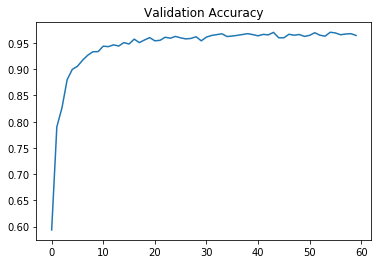

In [11]:
plt.plot(validation_accuracy_plot)
plt.title("Validation Accuracy")
plt.show()

In [12]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    train_accuracy = evaluate(X_train, y_train)
    print("Train Accuracy = {:.2f}%".format(100*train_accuracy))
    
    valid_accuracy = evaluate(X_valid, y_valid)
    print("Valid Accuracy = {:.2f}%".format(100*valid_accuracy))    
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy  = {:.2f}%".format(100*test_accuracy))

INFO:tensorflow:Restoring parameters from ./train_model.ckpt
Train Accuracy = 99.97%
Valid Accuracy = 96.44%
Test Accuracy  = 94.13%


### Notes:
Over 94% on all sets, although not 100% on the train set.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load and Output the Images

Preprocessing validation data...
Mean:   135.620528372  =>  2.33731163079e-17
Shape = (19, 32, 32, 1)


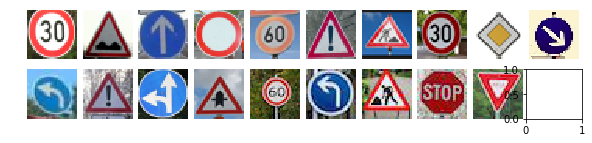

In [13]:
import os
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
print('Preprocessing validation data...')
extra_images = enumerate(sorted(glob.glob('./GTSExamples/*.*')))

#labels = [25, 34, 1, 25, 3, 15, 35, 22, 38, , , , , , , , , , ]
labels = [1, 22, 35, 15, 3, 18, 25, 1, 12, 38, 34, 18, 37, 11, 3, 34, 25, 14, 13]
extras = []

fig, axs = plt.subplots(2, 10, figsize=(10, 2))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i, img in extra_images:
    #print(i, img)
    image = cv2.imread(img)
    extras.append(image)
    axs[i].axis('off')
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

extras = np.asarray(extras)
(X_extras, y_extras) = ProcessDataSet(extras, labels)


### Predict the Sign Type for Each Image

In [14]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    extras_accuracy = evaluate(X_extras, labels)
    print("Extra set accuracy = {:.2f}%".format(100*extras_accuracy))
    

INFO:tensorflow:Restoring parameters from ./train_model.ckpt
Extra set accuracy = 84.21%


### Notes:
Depending on the run, there was always a group where two or three images never get recognised. This could be because these were some of the ones with very little training data, hence they fail to be recognised more often.

### Analyze Performance

In [15]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

for i in range(len(extras)):
    my_single_item_array = []
    my_single_item_label_array = []

    my_single_item_array.append(X_extras[i])
    my_single_item_label_array.append(y_extras[i])

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        my_accuracy = evaluate(my_single_item_array, my_single_item_label_array)
        print('Image {}'.format(i+1), ' (label: {})'.format(my_single_item_label_array[0]), " => Accuracy = {:.3f}".format(my_accuracy))
        print()
        

INFO:tensorflow:Restoring parameters from ./train_model.ckpt
Image 1  (label: 1)  => Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./train_model.ckpt
Image 2  (label: 22)  => Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./train_model.ckpt
Image 3  (label: 35)  => Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./train_model.ckpt
Image 4  (label: 15)  => Accuracy = 0.000

INFO:tensorflow:Restoring parameters from ./train_model.ckpt
Image 5  (label: 3)  => Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./train_model.ckpt
Image 6  (label: 18)  => Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./train_model.ckpt
Image 7  (label: 25)  => Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./train_model.ckpt
Image 8  (label: 1)  => Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./train_model.ckpt
Image 9  (label: 12)  => Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./train_model.ckpt
Image 

### Notes:
I could understand why for example men at work, (label 25) is not being predicted, since the image is mirrored and the training set probably only provided the other one, but I find it strange that it's not being able to predict other ones correctly, since they have no changes to the originals. 

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

INFO:tensorflow:Restoring parameters from ./train_model.ckpt


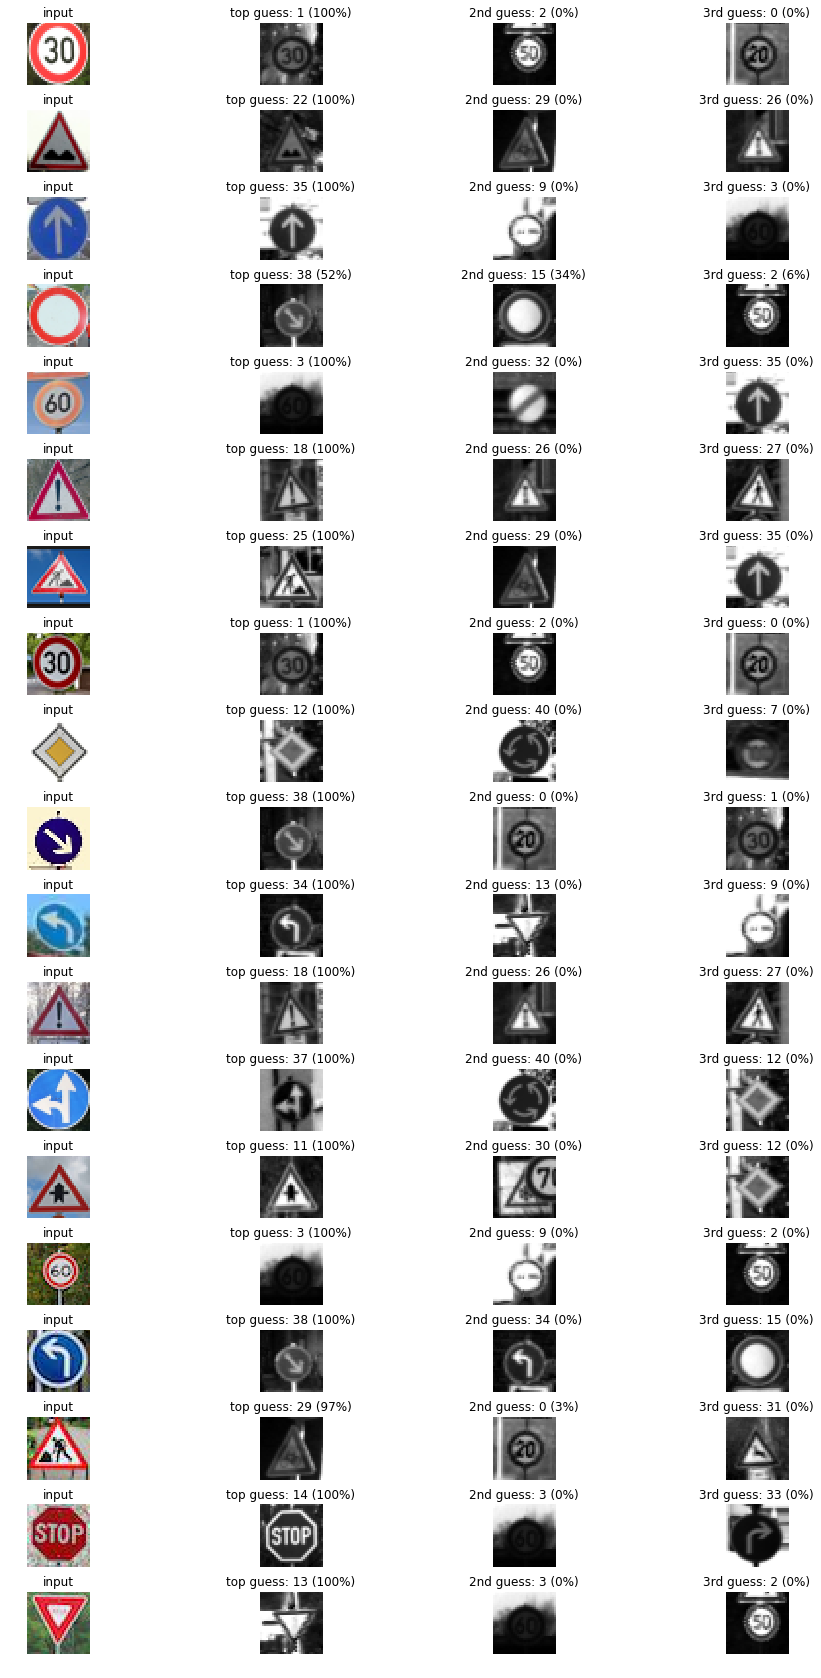

In [16]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: X_extras, keep_prob: 1.0})
    my_top_k = sess.run(top_k, feed_dict={x: X_extras, keep_prob: 1.0})
   
    fig, axs = plt.subplots(len(X_extras),4, figsize=(16, 30))
    fig.subplots_adjust(hspace = .4, wspace=.2)
    axs = axs.ravel()

    for i, image in enumerate(extras):
        axs[4*i].axis('off')
        axs[4*i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[4*i].set_title('input')
        guess = my_top_k[1][i][0]
        index = np.argwhere(y_validation == guess)[0]
        axs[4*i+1].axis('off')
        axs[4*i+1].imshow(X_validation[index].squeeze(), cmap='gray')
        axs[4*i+1].set_title('top guess: {} ({:.0f}%)'.format(guess, 100*my_top_k[0][i][0]))
        guess = my_top_k[1][i][1]
        index = np.argwhere(y_validation == guess)[0]
        axs[4*i+2].axis('off')
        axs[4*i+2].imshow(X_validation[index].squeeze(), cmap='gray')
        axs[4*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(guess, 100*my_top_k[0][i][1]))
        guess = my_top_k[1][i][2]
        index = np.argwhere(y_validation == guess)[0]
        axs[4*i+3].axis('off')
        axs[4*i+3].imshow(X_validation[index].squeeze(), cmap='gray')
        axs[4*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(guess, 100*my_top_k[0][i][2]))    
    

### Notes:
Mostly successful, if not, the 2nd guess got it.